Import necessary libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from IPython.display import clear_output
import time

Design a map which is able to
- update its data
- return its data
- display its data
- clear the display
- reset itself

In [2]:
class Custom_map:
    def __init__(self, data, name_col) -> None:
        self.data = data
        self.data['color'] = "white"
        self.name_col = name_col

    def get_data(self):
        return self.data
    
    def get_adj_mat(self):
        """
        Return adjacency matrix for agent to use
        """
        n = len(self.data)
        adjacency_matrix = np.zeros((n, n), dtype=int)
        for i, region in self.data.iterrows():
            for j, other_region in self.data.iterrows():
                if i != j and region.geometry.touches(other_region.geometry):
                    adjacency_matrix[i, j] = 1  # Mark as adjacent
        return pd.DataFrame(adjacency_matrix, index=self.data[self.name_col], columns=self.data[self.name_col])
    
    def update_region_colors(self, region_names, color):
        """
        Update region colour mapping to display
        """
        for name in region_names:
            self.data.loc[self.data[self.name_col] == name, 'color'] = color
    
    def show(self):
        """
        Plotting function
        """
        self.fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        self.data.boundary.plot(ax=ax, linewidth=1, color='black')  # Black boundaries
        self.data.plot(ax=ax, color=self.data['color'], edgecolor='black')  # Fill regions with chosen colors
        plt.axis('off')  # Turn off the axis
        plt.show()
        plt.close()
         
    def clear(self, delay):
        plt.pause(delay)
        clear_output(wait=True)

Load a map into our custom map

In [3]:
data = gpd.read_file("./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
m = Custom_map(data, "ADMIN")

Test if its working

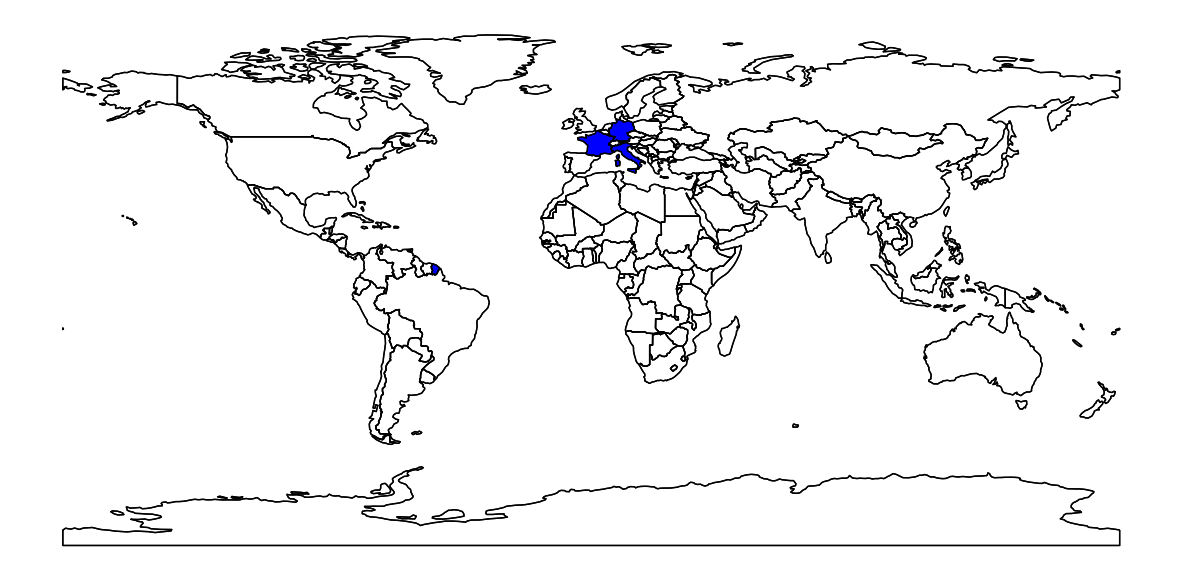

In [4]:
#Test
m.update_region_colors(['France', 'Germany', 'Italy'], "red")
m.show()
m.clear(delay=2)
m.update_region_colors(['France', 'Germany', 'Italy'], "blue")
m.show()

Design an agent which is able to colour the map such that no two adjacent regions have the same colour

In [5]:
class Agent:
    def __init__(self, colours, custom_map) -> None:
        make_colours = lambda x: {idx:i for idx, i in enumerate(x)}
        self.colours = make_colours(colours)
        self.colours[-1] = "white"
        self.map = custom_map
        self.adj_mat = custom_map.get_adj_mat()
        self.regions = self.adj_mat.index
        self.filled_colours = [-1]*len(self.adj_mat)

    def group_colours(self):
        region_map = defaultdict(list)
        for index, number in enumerate(self.filled_colours):
            region_map[number].append(self.regions[index])
        return dict(region_map)

    def plot(self):
        groups = self.group_colours()
        for color, regions in groups.items():
            self.map.update_region_colors(regions, self.colours[color])
        self.map.show()
        self.map.clear(delay=0)

    def solve(self, solution, vertex):
        tik = time.time()
        result = solution.solve(self.adj_mat, len(self.colours)-1, self.filled_colours, vertex, self)
        tok = time.time()
        print(f"Time elapsed: {tok-tik:.2f}")
        if (not result):
            print("No solution exists")
        else:
            self.plot()
        return


Designing the specific algorithm for our agent

Backtracking algorithm:
- Check for constraint violations before proceeding
- Backtrack to previous state to try something else if it is violated

In [6]:
#Uninformed search
class Backtracking:
    """
    Simple backtracking algorithm
    """
    def __init__(self) -> None:
        pass

    def is_valid(self, country_index, adj_mat, filled_colours, colour):
        for i, adj in enumerate(adj_mat.iloc[country_index]):
            if(adj and filled_colours[i]==colour):
                return 0
        return 1

    def solve(self, graph, m, colors, vertex, agent):
        if vertex == len(graph):
            return True
        for c in range(m):
            if self.is_valid(vertex, graph, colors, c):
                colors[vertex] = c
                agent.plot()
                if self.solve(graph, m, colors, vertex + 1, agent):
                    return True
                colors[vertex] = -1
        return False


Most Constraint Variable:
- Back-tracking
- Always choose the node with the most constraints on it (fewest colours available)

In [7]:
#Informed search
class MCV:
    """
    Simple Most Constraint Variable search
    """
    def __init__(self) -> None:
        pass

    def is_valid(self, country_index, adj_mat, filled_colours, colour):
        for i, adj in enumerate(adj_mat.iloc[country_index]):
            if(adj and filled_colours[i]==colour):
                return 0
        return 1

    def get_most_constrained_variable(self, df, color, m):
        min_options = float('inf')
        most_constrained = None
        for vertex in range(len(df.index)):
            if color[vertex] == -1:  # If the vertex is uncolored
                used_colors = set(color[i] for i in range(len(df.index)) if df.iloc[vertex, i] == 1 and color[i] != -1)
                available_colors = len(set(range(m)) - used_colors)
                if available_colors < min_options:
                    min_options = available_colors
                    most_constrained = vertex
                    
        return most_constrained
    
    def solve(self, graph, m, colors, vertex, agent):
        if all(c != -1 for c in colors):  # All vertices are colored
            return True
        u = self.get_most_constrained_variable(graph, colors, m)
        if u is None:
            return True
        for c in range(m):
            if self.is_valid(u, graph, colors, c):
                colors[u] = c
                agent.plot()
                if self.solve(graph, m, colors, u, agent):
                    return True
                colors[u] = -1
        return False

Least Constraining Value:
- Most Constraint Variable
- Choose colours based on how much it will constrain the number of colours neighbors can use
- Colours are chosen in ascending number of constraints

In [8]:
#Informed search
class MCV_LCV:
    """
    Simple MCV with added LCV
    """
    def __init__(self) -> None:
        pass
        
    def count_constrained_colors(self, matrix, colors, vertex, color, m):
        count = 0
        # Temporarily set vertex as color
        colors[vertex] = color
        
        for neighbor in range(len(matrix)):
            if matrix.iloc[vertex, neighbor] and colors[neighbor] == -1:  # Only count for uncolored neighbors
                # Count how many colors would be ruled out for this neighbor
                for c in range(m):
                    if not self.is_valid(neighbor, matrix, colors, c):
                        count += 1
        colors[vertex] = -1  # Reset the color of the vertex
        return count

    def least_constraining_value(self, matrix, colors, vertex, m):
        color_counts = []
        
        for color in range(m):
            if self.is_valid(vertex, matrix, colors, color):
                count = self.count_constrained_colors(matrix, colors, vertex, color, m)
                color_counts.append((count, color))
        
        # Sort by least constraining count (ascending)
        color_counts.sort()
        return [color for _, color in color_counts]

    def get_most_constrained_variable(self, df, color, m):
        min_options = float('inf')
        most_constrained = None
        for vertex in range(len(df.index)):
            if color[vertex] == -1:  # If the vertex is uncolored
                used_colors = set(color[i] for i in range(len(df.index)) if df.iloc[vertex, i] == 1 and color[i] != -1)
                available_colors = len(set(range(m)) - used_colors)
                if available_colors < min_options:
                    min_options = available_colors
                    most_constrained = vertex
                    
        return most_constrained
    
    def is_valid(self, country_index, adj_mat, filled_colours, colour):
        for i, adj in enumerate(adj_mat.iloc[country_index]):
            if(adj and filled_colours[i]==colour):
                return 0
        return 1

    def solve(self, graph, m, colors, vertex, agent):
        if all(c != -1 for c in colors):  # All vertices are colored
            return True
        u = self.get_most_constrained_variable(graph, colors, m)
        if u is None:
            return True
        for c in self.least_constraining_value(graph, colors, u, m): #Dont need check for validity since its alr done here
            colors[u] = c
            agent.plot()
            if self.solve(graph, m, colors, u, agent):
                return True
            colors[u] = -1
        return False


Time elapsed: 114.73


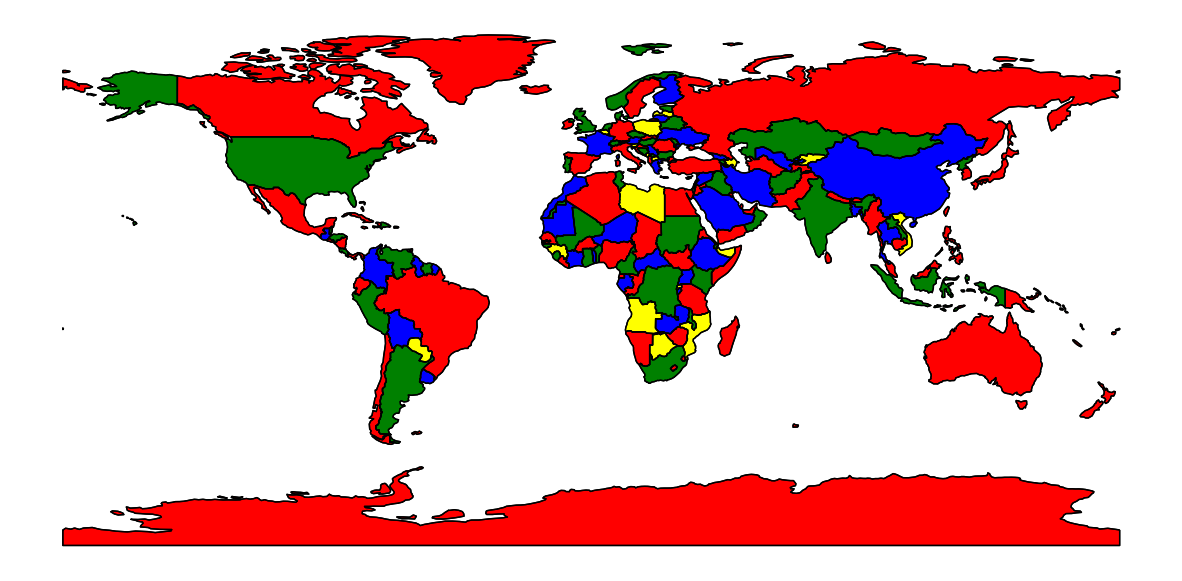

In [9]:
agent = Agent(["red", "green", "blue", "yellow"], m)
agent.solve(MCV(), 0)

Time elapsed: 111.68


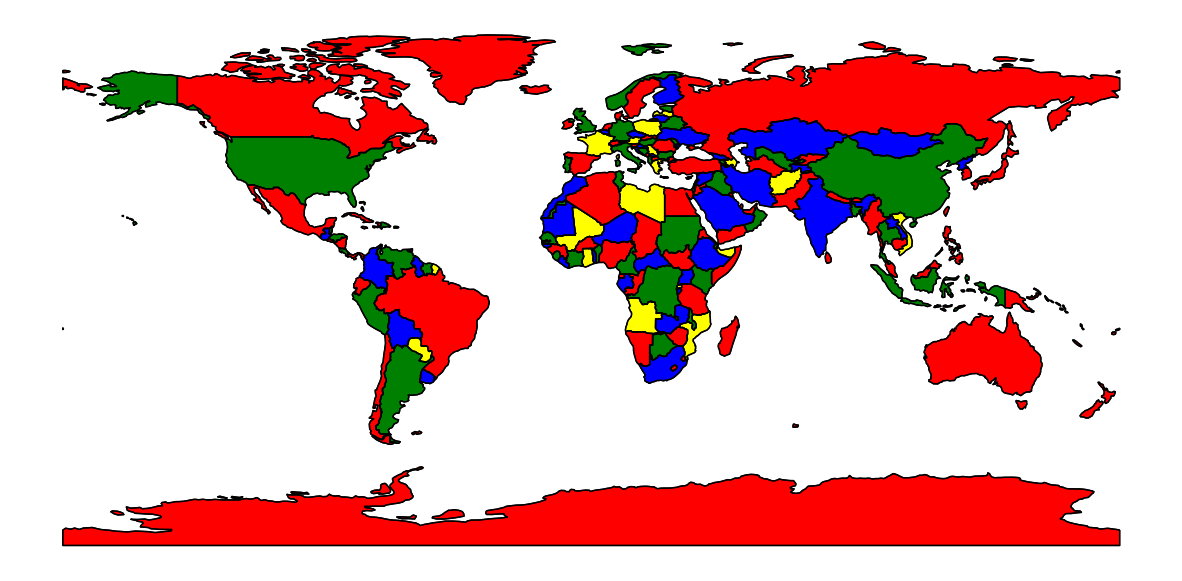

In [10]:
agent = Agent(["red", "green", "blue", "yellow"], m)
agent.solve(MCV_LCV(), 0)

In [1]:
#Takes forever with only 4 colors
agent = Agent(["red", "green", "blue", "yellow"], m)
agent.solve(Backtracking(), 0)

NameError: name 'Agent' is not defined

Algorithms from best to worst:
1) Most Constraint Variable
2) Least Constraint Value+Most Constraint Variable
3) Backtracking


Reasoning for ranking:
- Applying the MCV heuristic onto the Backtracking algorithm improved the search addressing the hardest decision first. This reduce search space early and minimize the amount of backtracking.
- Adding on the LCV heuristic worsened performance due to the low number of colours used, additional computation time to compute the heuristic did not produce any substantial gains
- Since our vertices are randomly scattered around the map visiting inorder of vertices pretty much results in our algorithm randomly colouring the map and brute forcing the solution once it gets stuck